In [1]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [2]:
paths = [Path(f"../league_{i}") for i in range(1, 5)]

dfs: list[pd.DataFrame] = []
names: set[str] = set()

for path in paths:
    df, league_names = create_dataframe(path)
    df["league"] = path.stem
    dfs.append(df)
    names = names.union(set(league_names))

names = list(names)
df = pd.concat(dfs, axis=0, ignore_index=True)

df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


In [14]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [3]:
df.sort_values("round_score", ascending=False)[["submitter", "round", "round_score"]]

,submitter,round,round_score
168,murray,Ich spreche kein Englisch 👽,29.0
617,Tim,👇 Straight to the point,26.0
465,fred,Sp00ky 👻,25.0
227,Jenny Seaborne,Best live version 🎤,24.0
113,Jamie,Film Soundtrack 🎞,23.0
...,...,...,...
267,sam24ahhhhhh,To the polls❌,-11.0
246,Olek,Best live version 🎤,-12.0
576,sam24ahhhhhh,Colours 🎨,-12.0
130,Olek,Film Soundtrack 🎞,-13.0


In [4]:
df.groupby("submitter")["round_score"].sum().sort_values(ascending=False)

submitter
Martha Mukungurutse         463.0
fred                        395.0
Jenny                       384.0
Helen Adams                 349.0
Jamie                       295.0
Russell                     283.0
Tim                         282.0
Mel Shallcrass              272.0
James Hardwick              265.0
Jenny Seaborne              242.0
murray                      234.0
Sacha Darwin                214.0
diplodocus.17               213.0
Tim            :)           202.0
Andrej Zacharenkov          149.0
Figataur                    145.0
Bethany Dickens-Devereux    138.0
Rory                        132.0
Sowdagar                    119.0
owainst                      94.0
Una                          78.0
sam24ahhhhhh                 69.0
Victoria Whitehead           50.0
Peter Rowe                   38.0
Olek                          6.0
Name: round_score, dtype: float64

In [5]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [6]:
artist_counts = Counter(df["artist_names"].explode())


In [7]:
counters: dict[str, Counter] = {}

for submitter, mini_df in df.groupby("submitter")["artist_names"]:
    print(f"{submitter:<25s} | {Counter(mini_df.explode()).most_common(3)}")




Andrej Zacharenkov        | [('t.A.T.u.', 2), ('Lady Gaga', 2), ('Cornelia Jakobs', 1)]
Bethany Dickens-Devereux  | [('Charli xcx', 2), ('Eleni Foureira', 1), ('Fugees', 1)]
Figataur                  | [('Carl Douglas', 1), ('The Specials', 1), ('Mirrorball', 1)]
Helen Adams               | [('Stevie Nicks', 2), ('Gina G.', 1), ('Fever Ray', 1)]
James Hardwick            | [('SHY FX', 2), ('Sunstroke', 1), ('Olia Tira', 1)]
Jamie                     | [('Eminem', 2), ('Käärijä', 1), ('The Last Dinner Party', 1)]
Jenny                     | [('Lizzo', 2), ('KEiiNO', 1), ('WARGASM (UK)', 1)]
Jenny Seaborne            | [('Wheatus', 1), ('Crazy Town', 1), ('Nirvana', 1)]
Martha Mukungurutse       | [('Dolly Parton', 2), ('Kraftwerk', 2), ('Nick Cave & The Bad Seeds', 2)]
Mel Shallcrass            | [('The White Stripes', 2), ('Barbara Pravi', 1), ('Wheeler Walker Jr.', 1)]
Olek                      | [('Justice', 3), ('khai dreams', 2), ('Lordi', 1)]
Peter Rowe                | [('The Bea

In [8]:
song_counts = Counter(df["song_name"].explode())
song_counts.most_common(3)

[('Zombie', 3), ('Here Comes the Hotstepper', 3), ('Cha Cha Cha', 2)]

## Round Winners

Who has won the most rounds

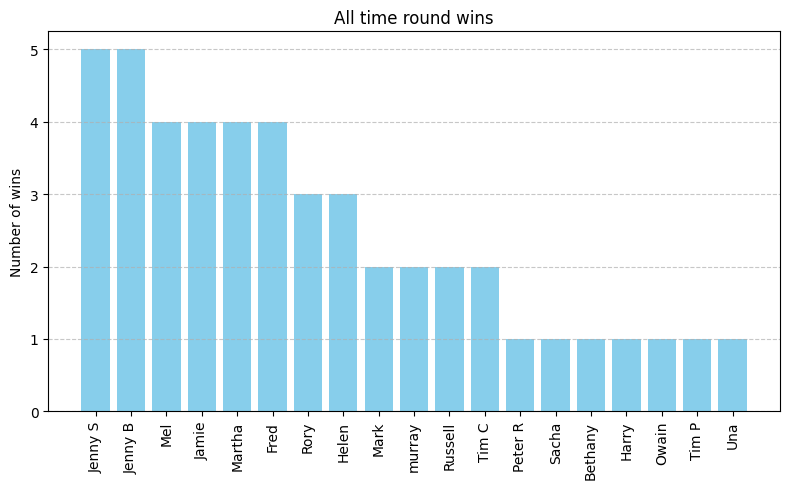

In [22]:
winners = Counter()

for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    for name in scores[scores["round_score"] == winning_score]["submitter"].values:
        winners[name] += 1

sorted_items = sorted(winners.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_items)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(labels, counts, color='skyblue')
plt.ylabel('Number of wins')
plt.title('All time round wins')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()